## Flight Price Prediction

#### Importing libraries which are going to use in this project

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn import metrics
sns.set()

## Importing dataset

##### Downloded from Kaggle  : https://www.kaggle.com/nikhilmittal/flight-fare-prediction-mh/

In [71]:
train_data = pd.read_excel(r"Data_Train.xlsx")

In [72]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [73]:
# info about data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [74]:
#Checking missing value
print(train_data.isnull().sum())
print(train_data.shape)

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64
(10683, 11)


In [75]:
# there are only two missing value one in "Route" and another one in "Total_Stops" we can drop this row'

train_data.dropna(inplace = True)
print(train_data.shape)

(10682, 11)


We don't have any missing values in the data. Now we can start the feature engineering part. We will have to modify the data as per the requirements of the project. We'll select each column and see what kind of changes we can make.

## Feature Engineering

### Date_of_Journey

Here we can see that "Date_of_Journey" column this date format will not work we have to separate this into day month and year.

In [76]:
# Here we are creating three new columns which keep day, month and year separately.
train_data["Journey_day"] = pd.to_datetime(train_data["Date_of_Journey"], format = "%d/%m/%Y").dt.day
train_data["Journey_month"] = pd.to_datetime(train_data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
train_data["Journey_year"] = pd.to_datetime(train_data["Date_of_Journey"], format = "%d/%m/%Y").dt.year

In [77]:
train_data.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Journey_year
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,2019
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5,2019


In [78]:
""" After converting the column "Date_of_Journey" we have noticed that "year" is the same throughout the column. 
"year" column will not help much so we can drop it and also drop "Date_of_Journey" column because it has already been converted 
into day and month """

print(train_data.Journey_year.value_counts())

train_data.drop(["Date_of_Journey","Journey_year"], axis = 1, inplace = True)

2019    10682
Name: Journey_year, dtype: int64


### Route

In [79]:
# so that I am going to drop this column.
train_data.drop(["Route"], axis = 1, inplace = True)

### Dep_Time ,  Arrival_Time and Duration

We need to do the same process as we did with the "Date_of_Journy" column. We have to separate the column into hour and minute.

In [80]:
# Dep_Time
# Extracting Hours
train_data["Dep_hour"] = pd.to_datetime(train_data["Dep_Time"]).dt.hour

# Extracting Minutes
train_data["Dep_min"] = pd.to_datetime(train_data["Dep_Time"]).dt.minute

# Now we can drop Dep_Time as it is of no use
train_data.drop(["Dep_Time"], axis = 1, inplace = True)

""" Now we have Arrival_Time and Duration. I think it is better to use either of these two columns,
as both are giving same information we can easily calculate arrival time with the help of Dep_Time and Duration.
I am going to keep "Duration" column and drop "Arrival_Time" """

# droping Arrival_Time

train_data.drop(["Arrival_Time"], axis = 1, inplace = True)

'\nduration = list(train_data["Duration"])\n\nfor i in range(len(duration)):\n    if len(duration[i].split()) != 2:    # Check if duration contains only hour or mins\n        if "h" in duration[i]:\n            duration[i] = duration[i].strip() + " 0m"   # Adds 0 minute\n        else:\n            duration[i] = "0h " + duration[i]           # Adds 0 hour\n\nduration_hours = []\nduration_mins = []\nfor i in range(len(duration)):\n    duration_hours.append(int(duration[i].split(sep = "h")[0]))    # Extract hours from duration\n    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   # Extracts only minutes from duration\n\n\n# Adding duration_hours and duration_mins list to train_data dataframe\n\ntrain_data["Duration_hours"] = duration_hours\ntrain_data["Duration_mins"] = duration_mins\n\n# After converting we can drop "Duration" column\n\ntrain_data.drop(["Duration"], axis = 1, inplace = True)\n\n'

In [81]:
# Converting all durations into minutes

def duration_convertion(x):
    if len(x.split()) == 2:
        one = int(x.split()[0][:-1])
        two = int(x.split()[1][:-1])
        return one * 60 + two
    else:
        return int(x[:-1]) * 60

In [82]:
train_data["Duration"] = train_data["Duration"].apply(duration_convertion)

In [83]:
train_data.head()

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,170,non-stop,No info,3897,24,3,22,20
1,Air India,Kolkata,Banglore,445,2 stops,No info,7662,1,5,5,50
2,Jet Airways,Delhi,Cochin,1140,2 stops,No info,13882,9,6,9,25
3,IndiGo,Kolkata,Banglore,325,1 stop,No info,6218,12,5,18,5
4,IndiGo,Banglore,New Delhi,285,1 stop,No info,13302,1,3,16,50


### Additional_Info	

In [84]:
train_data['Additional_Info'].value_counts(normalize=True)*100

No info                         78.112713
In-flight meal not included     18.554578
No check-in baggage included     2.995694
1 Long layover                   0.177869
Change airports                  0.065531
Business class                   0.037446
No Info                          0.028085
1 Short layover                  0.009362
2 Long layover                   0.009362
Red-eye flight                   0.009362
Name: Additional_Info, dtype: float64

In [85]:
# Around 80% we have no information in this column so I am not including this column.
train_data.drop(["Additional_Info"], axis = 1, inplace = True)

In [86]:
train_data.head(3)
# Now it looks good we almost done the feature enginnering part.

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min
0,IndiGo,Banglore,New Delhi,170,non-stop,3897,24,3,22,20
1,Air India,Kolkata,Banglore,445,2 stops,7662,1,5,5,50
2,Jet Airways,Delhi,Cochin,1140,2 stops,13882,9,6,9,25


In [87]:
train_data.info()
# Now we have four columns with object data type. We have to convert into numeric to apply ML Algo.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Airline        10682 non-null  object
 1   Source         10682 non-null  object
 2   Destination    10682 non-null  object
 3   Duration       10682 non-null  int64 
 4   Total_Stops    10682 non-null  object
 5   Price          10682 non-null  int64 
 6   Journey_day    10682 non-null  int64 
 7   Journey_month  10682 non-null  int64 
 8   Dep_hour       10682 non-null  int64 
 9   Dep_min        10682 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 918.0+ KB


### Airline , Source , Destination and Total_Stops

In [88]:
print('\33[1m'"Airline" '\33[m')
print("-"*50)
print(train_data.Airline.value_counts())

print('\n','\33[1m'"Source" '\33[m')
print("-"*50)
print(train_data.Source.value_counts())

print('\n','\33[1m'"Destination" '\33[m')
print("-"*50)
print(train_data.Destination.value_counts())

print('\n','\33[1m'"Total Stops" '\33[m')
print("-"*50)
print(train_data.Total_Stops.value_counts())

Airline
--------------------------------------------------
Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

 Source
--------------------------------------------------
Delhi       4536
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

 Destination
--------------------------------------------------
Cochin       4536
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

 Total Stops
------------------

These are nominal categorical data. I am going to use "OneHotEncoder" 

In [89]:
# Airline
Airline_new = train_data[["Airline"]]

Airline_new = pd.get_dummies(Airline_new, drop_first= True)

# Source
Source_new = train_data[["Source"]]

Source_new = pd.get_dummies(Source_new, drop_first= True)

# Destination
Destination_new = train_data[["Destination"]]

Destination_new = pd.get_dummies(Destination_new, drop_first = True)

# Total_Stops

# Here I am not using OneHotEncoder just assigned values with corresponding keys

train_data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

# drop the column 
train_data.drop(["Airline","Source","Destination"], axis = 1, inplace = True)

# Concatenate dataframe --> train_data + Airline + Source + Destination

data_train = pd.concat([train_data, Airline_new, Source_new, Destination_new], axis = 1)



In [90]:
data_train.head()

,Duration,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Airline_Air India,Airline_GoAir,Airline_IndiGo,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,170,0,3897,24,3,22,20,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,445,2,7662,1,5,5,50,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1140,2,13882,9,6,9,25,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,325,1,6218,12,5,18,5,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,285,1,13302,1,3,16,50,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [91]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 27 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Duration                                   10682 non-null  int64
 1   Total_Stops                                10682 non-null  int64
 2   Price                                      10682 non-null  int64
 3   Journey_day                                10682 non-null  int64
 4   Journey_month                              10682 non-null  int64
 5   Dep_hour                                   10682 non-null  int64
 6   Dep_min                                    10682 non-null  int64
 7   Airline_Air India                          10682 non-null  uint8
 8   Airline_GoAir                              10682 non-null  uint8
 9   Airline_IndiGo                             10682 non-null  uint8
 10  Airline_Jet Airways                        106

## Feature Selection

Using Lasso regression for feature selection

Lasso regression will select only those features that are useful, discard the useless or redundant features. In Lasso regression, discarding a feature will make its coefficient = 0.

In [92]:
X=data_train.drop(['Price'],axis=1)
y=data_train['Price']

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [94]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

In [95]:
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [96]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV] model__alpha=0.1 ................................................
[CV] ............. model__alpha=0.1, score=-6970553.351, total=   0.1s
[CV] model__alpha=0.1 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............. model__alpha=0.1, score=-6841933.105, total=   0.1s
[CV] model__alpha=0.1 ................................................
[CV] ............. model__alpha=0.1, score=-9228201.090, total=   0.1s
[CV] model__alpha=0.1 ................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ............. model__alpha=0.1, score=-9965138.343, total=   0.1s
[CV] model__alpha=0.1 ................................................
[CV] ............. model__alpha=0.1, score=-7444405.497, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] ............. model__alpha=0.2, score=-6970485.480, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] ............. model__alpha=0.2, score=-6841872.585, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] ............. model__alpha=0.2, score=-9228358.208, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] ............. model__alpha=0.2, score=-9964991.888, total=   0.1s
[CV] model__alpha=0.2 ................................................
[CV] ............. model__alpha=0.2, score=-7444341.916, total=   0.1s
[CV] model__alpha=0.30000000000000004 ................................
[CV]  

[CV]  model__alpha=1.3000000000000003, score=-6969935.017, total=   0.1s
[CV] model__alpha=1.3000000000000003 .................................
[CV]  model__alpha=1.3000000000000003, score=-6841369.740, total=   0.0s
[CV] model__alpha=1.3000000000000003 .................................
[CV]  model__alpha=1.3000000000000003, score=-9229781.723, total=   0.0s
[CV] model__alpha=1.3000000000000003 .................................
[CV]  model__alpha=1.3000000000000003, score=-9963512.630, total=   0.0s
[CV] model__alpha=1.3000000000000003 .................................
[CV]  model__alpha=1.3000000000000003, score=-7443782.211, total=   0.0s
[CV] model__alpha=1.4000000000000001 .................................
[CV]  model__alpha=1.4000000000000001, score=-6969901.933, total=   0.0s
[CV] model__alpha=1.4000000000000001 .................................
[CV]  model__alpha=1.4000000000000001, score=-6841339.617, total=   0.0s
[CV] model__alpha=1.4000000000000001 ..........................

[CV]  model__alpha=2.4000000000000004, score=-9231340.506, total=   0.0s
[CV] model__alpha=2.4000000000000004 .................................
[CV]  model__alpha=2.4000000000000004, score=-9962304.285, total=   0.0s
[CV] model__alpha=2.4000000000000004 .................................
[CV]  model__alpha=2.4000000000000004, score=-7443519.852, total=   0.0s
[CV] model__alpha=2.5000000000000004 .................................
[CV]  model__alpha=2.5000000000000004, score=-6969718.189, total=   0.0s
[CV] model__alpha=2.5000000000000004 .................................
[CV]  model__alpha=2.5000000000000004, score=-6841170.895, total=   0.0s
[CV] model__alpha=2.5000000000000004 .................................
[CV]  model__alpha=2.5000000000000004, score=-9231497.712, total=   0.0s
[CV] model__alpha=2.5000000000000004 .................................
[CV]  model__alpha=2.5000000000000004, score=-9962207.537, total=   0.0s
[CV] model__alpha=2.5000000000000004 ..........................

[CV]  model__alpha=3.5000000000000004, score=-7443550.006, total=   0.0s
[CV] model__alpha=3.6 ................................................
[CV] ............. model__alpha=3.6, score=-6969029.868, total=   0.0s
[CV] model__alpha=3.6 ................................................
[CV] ............. model__alpha=3.6, score=-6840919.248, total=   0.0s
[CV] model__alpha=3.6 ................................................
[CV] ............. model__alpha=3.6, score=-9233331.305, total=   0.0s
[CV] model__alpha=3.6 ................................................
[CV] ............. model__alpha=3.6, score=-9960402.704, total=   0.0s
[CV] model__alpha=3.6 ................................................
[CV] ............. model__alpha=3.6, score=-7443568.608, total=   0.0s
[CV] model__alpha=3.7 ................................................
[CV] ............. model__alpha=3.7, score=-6968945.167, total=   0.0s
[CV] model__alpha=3.7 ................................................
[CV]

[CV] ............. model__alpha=4.8, score=-6967991.354, total=   0.0s
[CV] model__alpha=4.8 ................................................
[CV] ............. model__alpha=4.8, score=-6840645.180, total=   0.0s
[CV] model__alpha=4.8 ................................................
[CV] ............. model__alpha=4.8, score=-9235200.680, total=   0.0s
[CV] model__alpha=4.8 ................................................
[CV] ............. model__alpha=4.8, score=-9958159.541, total=   0.0s
[CV] model__alpha=4.8 ................................................
[CV] ............. model__alpha=4.8, score=-7443851.682, total=   0.0s
[CV] model__alpha=4.9 ................................................
[CV] ............. model__alpha=4.9, score=-6967893.878, total=   0.0s
[CV] model__alpha=4.9 ................................................
[CV] ............. model__alpha=4.9, score=-6840622.585, total=   0.0s
[CV] model__alpha=4.9 ................................................
[CV] .

[CV] ............. model__alpha=5.9, score=-7444191.158, total=   0.0s
[CV] model__alpha=6.0 ................................................
[CV] ............. model__alpha=6.0, score=-6967830.611, total=   0.0s
[CV] model__alpha=6.0 ................................................
[CV] ............. model__alpha=6.0, score=-6840387.868, total=   0.0s
[CV] model__alpha=6.0 ................................................
[CV] ............. model__alpha=6.0, score=-9236933.388, total=   0.0s
[CV] model__alpha=6.0 ................................................
[CV] ............. model__alpha=6.0, score=-9956083.775, total=   0.0s
[CV] model__alpha=6.0 ................................................
[CV] ............. model__alpha=6.0, score=-7444224.101, total=   0.0s
[CV] model__alpha=6.1 ................................................
[CV] ............. model__alpha=6.1, score=-6967885.554, total=   0.0s
[CV] model__alpha=6.1 ................................................
[CV] .

[CV] ............. model__alpha=7.2, score=-6968691.059, total=   0.0s
[CV] model__alpha=7.2 ................................................
[CV] ............. model__alpha=7.2, score=-6840213.754, total=   0.0s
[CV] model__alpha=7.2 ................................................
[CV] ............. model__alpha=7.2, score=-9238716.977, total=   0.0s
[CV] model__alpha=7.2 ................................................
[CV] ............. model__alpha=7.2, score=-9954534.747, total=   0.0s
[CV] model__alpha=7.2 ................................................
[CV] ............. model__alpha=7.2, score=-7444633.545, total=   0.0s
[CV] model__alpha=7.3 ................................................
[CV] ............. model__alpha=7.3, score=-6968766.958, total=   0.0s
[CV] model__alpha=7.3 ................................................
[CV] ............. model__alpha=7.3, score=-6840201.108, total=   0.0s
[CV] model__alpha=7.3 ................................................
[CV] .

[CV] ............. model__alpha=8.4, score=-6840187.100, total=   0.0s
[CV] model__alpha=8.4 ................................................
[CV] ............. model__alpha=8.4, score=-9240562.098, total=   0.0s
[CV] model__alpha=8.4 ................................................
[CV] ............. model__alpha=8.4, score=-9953089.959, total=   0.0s
[CV] model__alpha=8.4 ................................................
[CV] ............. model__alpha=8.4, score=-7445067.097, total=   0.0s
[CV] model__alpha=8.5 ................................................
[CV] ............. model__alpha=8.5, score=-6969725.421, total=   0.0s
[CV] model__alpha=8.5 ................................................
[CV] ............. model__alpha=8.5, score=-6840194.798, total=   0.0s
[CV] model__alpha=8.5 ................................................
[CV] ............. model__alpha=8.5, score=-9240711.666, total=   0.0s
[CV] model__alpha=8.5 ................................................
[CV] .

[CV] ............. model__alpha=9.6, score=-9951719.554, total=   0.0s
[CV] model__alpha=9.6 ................................................
[CV] ............. model__alpha=9.6, score=-7445552.622, total=   0.0s
[CV] model__alpha=9.700000000000001 ..................................
[CV]  model__alpha=9.700000000000001, score=-6970758.095, total=   0.0s
[CV] model__alpha=9.700000000000001 ..................................
[CV]  model__alpha=9.700000000000001, score=-6840232.289, total=   0.0s
[CV] model__alpha=9.700000000000001 ..................................
[CV]  model__alpha=9.700000000000001, score=-9242644.865, total=   0.0s
[CV] model__alpha=9.700000000000001 ..................................
[CV]  model__alpha=9.700000000000001, score=-9951608.767, total=   0.0s
[CV] model__alpha=9.700000000000001 ..................................
[CV]  model__alpha=9.700000000000001, score=-7445602.236, total=   0.0s
[CV] model__alpha=9.8 ................................................
[

[Parallel(n_jobs=1)]: Done 495 out of 495 | elapsed:   18.2s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [97]:
search.best_params_

{'model__alpha': 5.6}

In [98]:
coefficients = search.best_estimator_.named_steps['model'].coef_

In [99]:
importance = np.abs(coefficients)

In [100]:
importance.shape

(26,)

In [101]:
features = np.array(list(X.columns))

In [102]:
features.shape

(26,)

In [103]:
features

array(['Duration', 'Total_Stops', 'Journey_day', 'Journey_month',
       'Dep_hour', 'Dep_min', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara',
       'Airline_Vistara Premium economy', 'Source_Chennai',
       'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'], dtype='<U41')

In [104]:
"""Here we are finding that features have coefficient value is = 0,it means these features are not useful 
we can drop these columns."""
np.array(features)[importance == 0]

array(['Airline_GoAir', 'Airline_IndiGo', 'Source_Chennai',
       'Source_Kolkata', 'Destination_Cochin'], dtype='<U41')

In [105]:
X.drop(['Airline_GoAir', 'Airline_IndiGo', 'Source_Chennai',
       'Source_Kolkata', 'Destination_Cochin'],axis=1,inplace=True)

In [106]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 21 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Duration                                   10682 non-null  int64
 1   Total_Stops                                10682 non-null  int64
 2   Journey_day                                10682 non-null  int64
 3   Journey_month                              10682 non-null  int64
 4   Dep_hour                                   10682 non-null  int64
 5   Dep_min                                    10682 non-null  int64
 6   Airline_Air India                          10682 non-null  uint8
 7   Airline_Jet Airways                        10682 non-null  uint8
 8   Airline_Jet Airways Business               10682 non-null  uint8
 9   Airline_Multiple carriers                  10682 non-null  uint8
 10  Airline_Multiple carriers Premium economy  106

### Now Using Variance Inflation Factor- VIF to check multicollinearity in the data.

In [107]:
scaler =StandardScaler()

X_scaled = scaler.fit_transform(X)

In [108]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X_scaled

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
# we do not include categorical values for mulitcollinearity as they do not provide much information as numerical ones do
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = X.columns

C:\Users\Ashwani\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [109]:
vif

,VIF,Features
0,2.572532,Duration
1,3.253046,Total_Stops
2,1.026795,Journey_day
3,1.304486,Journey_month
4,1.057731,Dep_hour
5,1.060577,Dep_min
6,1.877843,Airline_Air India
7,2.109878,Airline_Jet Airways
8,1.007742,Airline_Jet Airways Business
9,1.583199,Airline_Multiple carriers


In [110]:
"""If the VIF score is greater than 5 it indicates that the independent features are highly correlated to each other.
Here we have two features but both are categorical. It doesn't affect much we can keep it."""
np.array(vif[vif.VIF > 5]["Features"])

array(['Source_Mumbai', 'Destination_Hyderabad'], dtype=object)

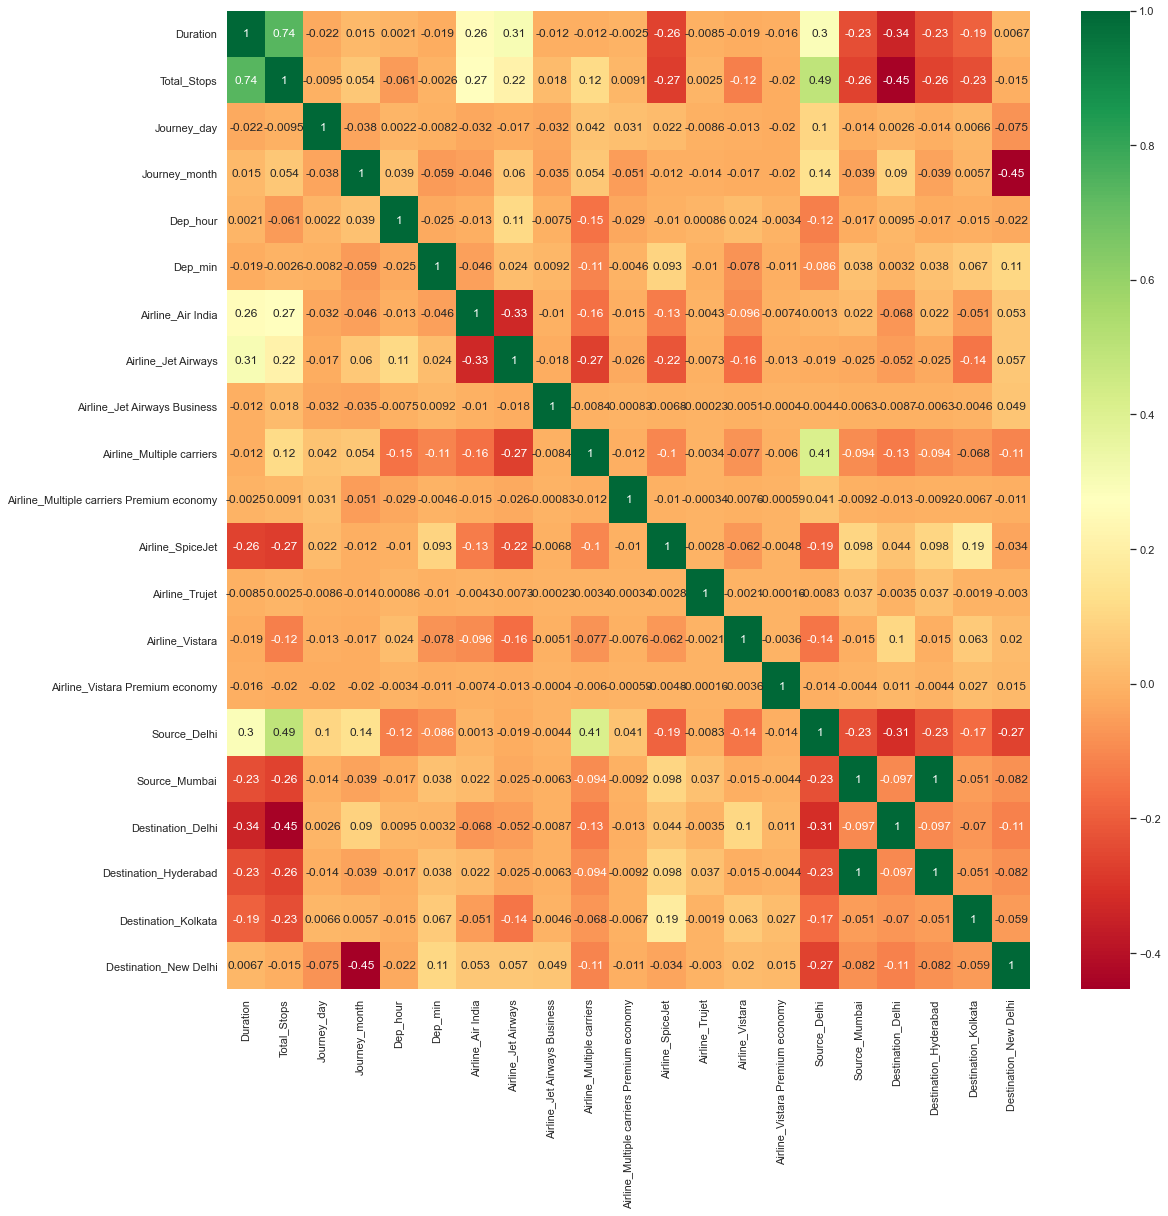

In [111]:
# Find correlation scores using headmap.

plt.figure(figsize = (18,18))
sns.heatmap(X.corr(), annot = True, cmap = "RdYlGn")

plt.show()

Now the data looks good to train the model

# Training the Model

## Find best model using GridSearchCV

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 42)

In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        },
        'Random_Forest': {
            'model': RandomForestRegressor(),
            'params': {
                'criterion' : ['mse','mae']
            }             
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,linear_regression,0.624518,{'normalize': True}
1,lasso,0.624104,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.703576,"{'criterion': 'friedman_mse', 'splitter': 'best'}"
3,Random_Forest,0.821289,{'criterion': 'mae'}


## Based on above results we can say that RandomForestRegressor gives the best score. 

In [114]:
rf_reg = RandomForestRegressor(criterion='mae')
rf_reg.fit(X_train, y_train)

RandomForestRegressor(criterion='mae')

In [115]:
rf_reg.score(X_train, y_train)

0.9425930235567367

In [117]:
rf_reg.score(X_test, y_test)

0.8230218561519559

# Predicting Test Data

In [118]:
predictions = rf_reg.predict(X_test)

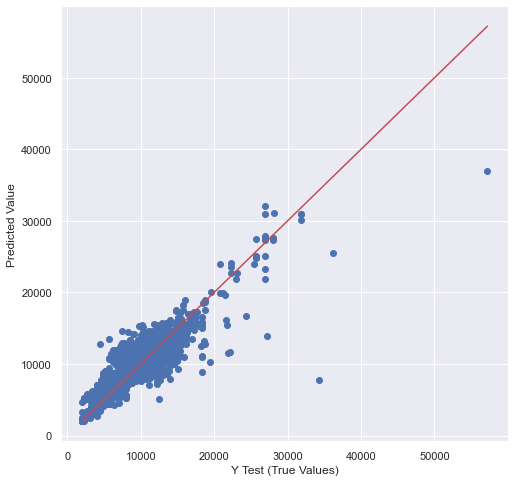

In [119]:
plt.figure(figsize = (8,8))
plt.scatter(y_test,predictions)
plt.xlabel('Y Test (True Values)')
plt.ylabel('Predicted Value')
x = np.linspace(min(y_test) , max(y_test) , 100)
y = x
plt.plot(x, y , "-r")
plt.show()

# Evaluating the Model

In [120]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions))) 

MAE: 1192.6839424426767
MSE: 3816012.705797134
RMSE: 1953.4617236580639


In [121]:
metrics.explained_variance_score(y_test,predictions)

0.8232938768022339

C:\Users\Ashwani\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


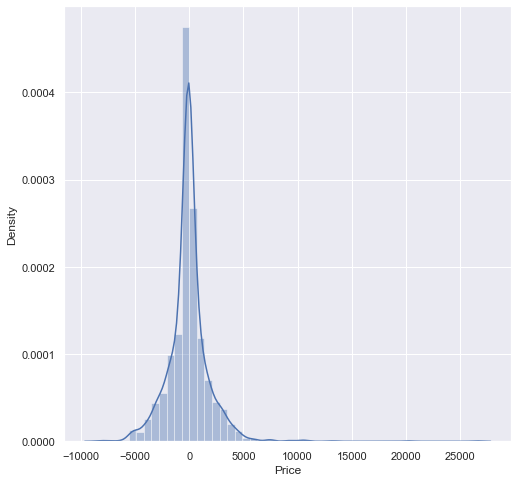

In [122]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-predictions)
plt.show()

## Saving the model 

In [127]:
import pickle
# open a file, where we want to store the data
file = open('flight_final.pkl', 'wb')

# dump information to that file
pickle.dump(rf_reg, file)

In [128]:
model = open('flight_final.pkl','rb')
random_forest = pickle.load(model)

In [129]:
y_prediction = random_forest.predict(X_test)

In [130]:
metrics.r2_score(y_test, y_prediction)

0.8230218561519559